In [7]:
import metmhn.simulations as simul
import metmhn.Utilityfunctions as utils
import pandas as pd
import numpy as np
import jax as jax
from jax import numpy as jnp
from jax import random as jrp
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("default")

seed = 43000
key = jrp.key(seed)

Read in the metMHN, learned on the reduced LUAD-dataset in `examples/data_analysis.pynb`:

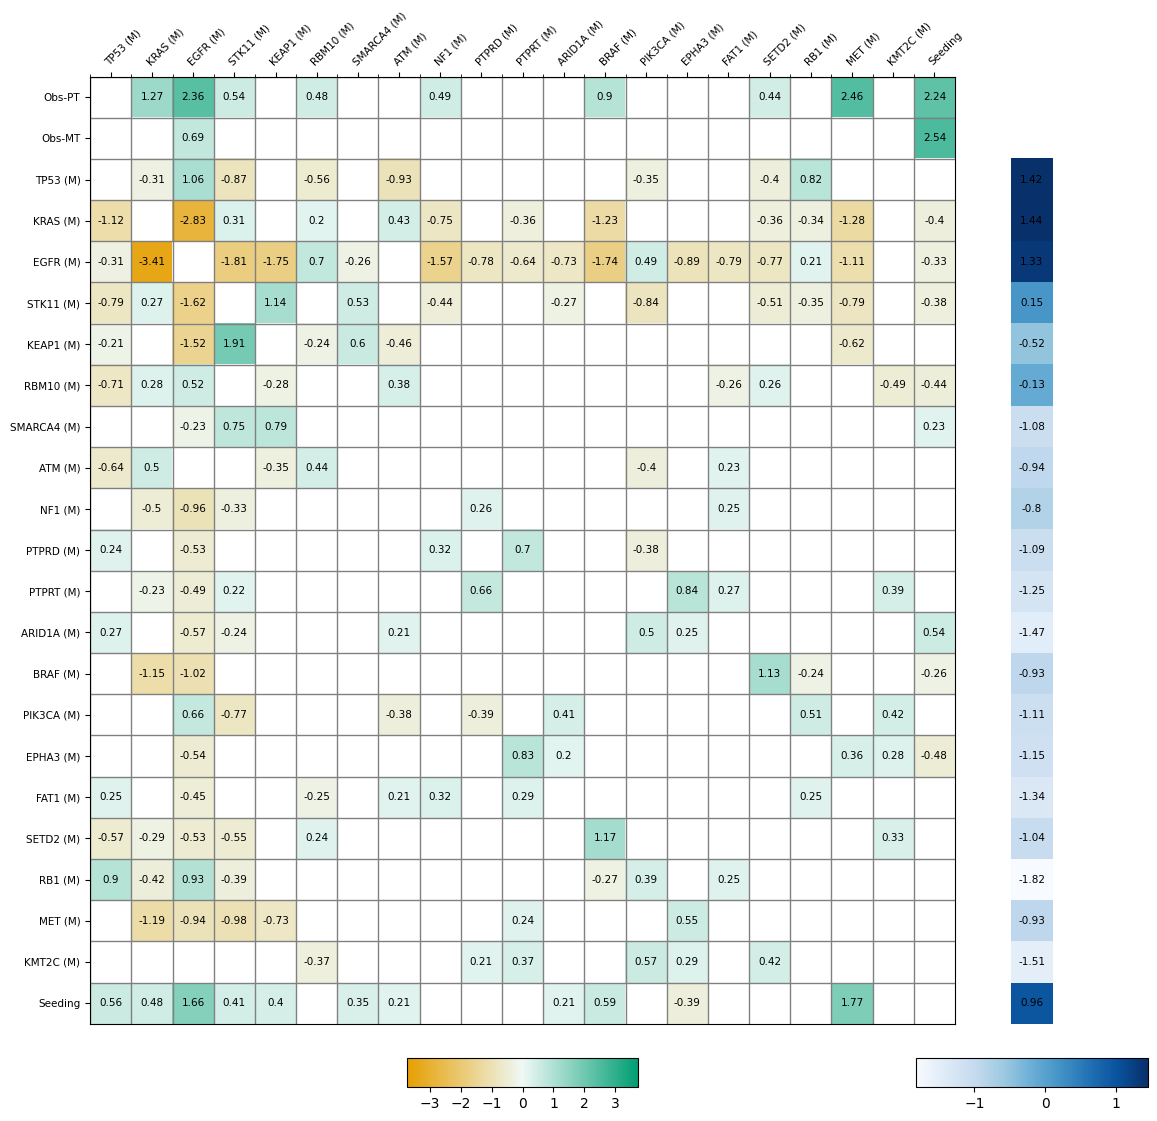

In [8]:
params = pd.read_csv("../results/luad/luad_g14_20muts.csv", index_col=0)
d_p = jnp.array(params.iloc[0,:].to_numpy())
d_m = jnp.array(params.iloc[1, :].to_numpy())
th = jnp.array(params.iloc[2:,:].to_numpy())
events = params.columns
n = th.shape[1]
fig, (ax1, ax2) = plt.subplots(1,2, sharey="col", figsize=(23,15),
                                gridspec_kw={'width_ratios': [n, 1], "wspace": -0.6})
utils.plot_theta(ax1, ax2, params.to_numpy(), events, alpha=0.2, verbose=True, font_size=7.5)
plt.show()

Generate a dataset containing full trajectories of tumors.
NOTE: We're using the [jax.random](https://jax.readthedocs.io/en/latest/jax.random.html) module to generate pseudo random numbers for our simulations. Unlike the numpy random number generators (rngs), jax rngs require an explicit PRNG-state as an argument. This random state is for example returned by the `jrp.key(seed)` function. **Importantly, passing the same key to one of our simulation functions will always result in the exact same results.** For more information on jax random keys we refer to the documentation of the jax.random module.

In [9]:
# Split the current key into a subkey to use for the current simulation and a key to use for the next simulations
key, sub_key = jrp.split(key)
trajectories = simul.simulate_orders(log_theta=th, 
                                     pt_d_ef = d_p, 
                                     mt_d_ef = d_m, 
                                     n_sim = 50000, 
                                     original_key = sub_key)

Calculate $P(t_{mut} < t_{seed}| met[mut] = 1)$ i.e. the probability that a mutation happend prior to the seeding conditioned on the mutation being present in the metastasis:

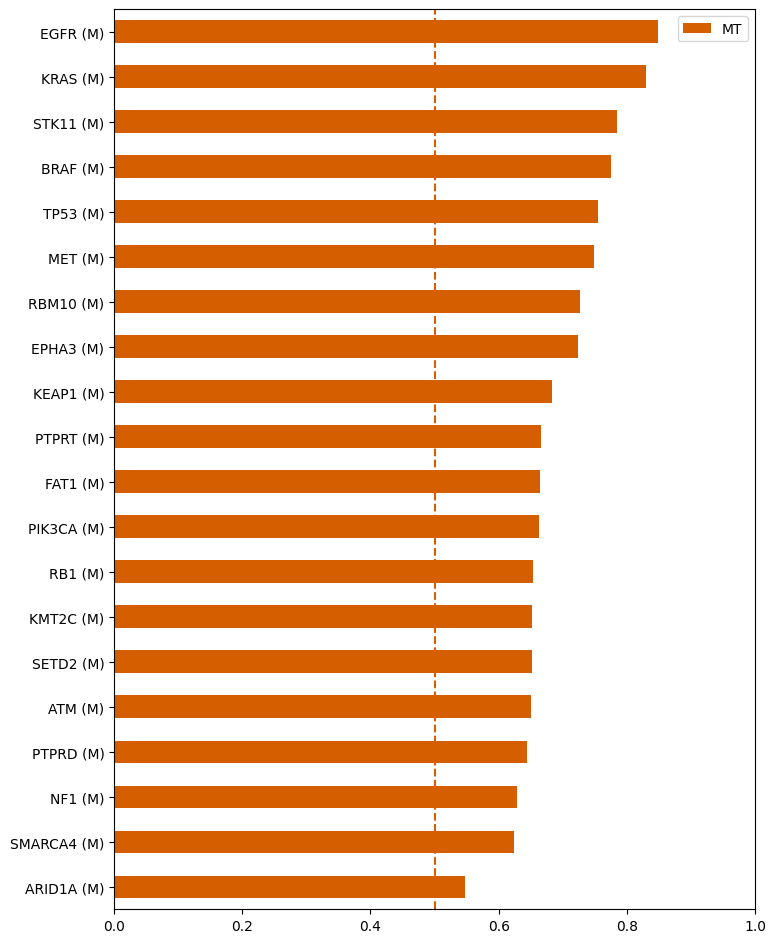

In [10]:
psp_prim_cond, psp_met_cond = simul.preseeding_probs(dat = trajectories, 
                                                     n = n, 
                                                     seeding_num = 20)

psp = pd.DataFrame(np.column_stack((psp_prim_cond, psp_met_cond)), 
                  index=events[:-1], columns=["PT", "MT"])
psp.sort_values(by=["MT"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["MT"].plot(kind="barh", ax=ax, color="#D55E00")
ax.legend()
plt.show()

Simulate synthetic data using Gillespie's algorithm of tumor genotypes (i.e. no trajectory information):

In [11]:
# Split the current key into a subkey to use for the current simulation and a key to use for the next simulations
key, sub_key = jrp.split(key)
dat = np.array(simul.simulate_dat(log_theta = th, 
                                  pt_d_ef = d_p, 
                                  mt_d_ef = d_m, 
                                  n_sim = 50000, 
                                  original_key = sub_key)
                                  )
dat_prim_nomet = dat[dat[:,-2]==0,:-1]
dat_coupled = dat[dat[:,-2]==1,:-1]
dat_pt_first = dat[dat[:, -1] != 2, :]

Plot the marginal frequencies of each event:

In [12]:
n_mut = (th.shape[0]-1)
n_tot = n_mut + 1
arr = dat_coupled * np.array([1,2]*n_mut+[1])
arr = arr @ (np.diag([1,0]*n_mut+[1]) + np.diag([1,0]*n_mut, -1))

counts = np.zeros((4, n_tot))
for i in range(0,2*n_tot,2):
    i_h = int(i/2)
    for j in range(1,4):
        counts[j-1, i_h] = np.count_nonzero(arr[:,i]==j)/dat_coupled.shape[0]
    counts[3, i_h] = np.sum(dat_prim_nomet[:, i], axis=0)/dat_prim_nomet.shape[0]

labels = [["Coupled ("+str(dat_coupled.shape[0])+")"]*3 +\
        ["NM ("+str(dat_prim_nomet.shape[0])+")"],
        ["PT-Private", "MT-Private", "Shared"] + ["Present"]*3]
       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
counts = pd.DataFrame(np.around(counts, 2), columns=events, index=inds).T
counts

Coupled (32352)                   NM (17648)
                 PT-Private MT-Private Shared    Present
TP53 (M)               0.05       0.11   0.43       0.28
KRAS (M)               0.06       0.04   0.26       0.37
EGFR (M)               0.05       0.04   0.25       0.30
STK11 (M)              0.03       0.03   0.12       0.13
KEAP1 (M)              0.02       0.04   0.09       0.07
RBM10 (M)              0.02       0.03   0.08       0.14
SMARCA4 (M)            0.01       0.03   0.05       0.03
ATM (M)                0.01       0.03   0.05       0.05
NF1 (M)                0.01       0.03   0.05       0.06
PTPRD (M)              0.01       0.02   0.05       0.04
PTPRT (M)              0.01       0.02   0.04       0.03
ARID1A (M)             0.01       0.03   0.03       0.03
BRAF (M)               0.01       0.01   0.04       0.04
PIK3CA (M)             0.01       0.02   0.04       0.05
EPHA3 (M)              0.01       0.01   0.03       0.05
FAT1 (M)               0.01       0.02   0.04       0.03
SETD2 (M)              0.01       0.02   0.03       0.05
RB1 (M)                0.01       0.02   0.03       0.03
MET (M)                0.01       0.01   0.03       0.05
KMT2C (M)              0.01       0.02   0.03       0.03
Seeding                1.00       0.00   0.00       0.00